In [222]:
import re
import numpy as np
import pickle
import pandas as pd
from collections import Counter

import spacy
import textacy
from textblob import TextBlob

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

data_path = '/Users/eb/Google Drive/Research/text_words_meaning/twm-slides/notebooks/data/'

In [280]:
def spacy_pipe(nlp):
    """Custom spacy pipeline."""
    return(nlp.tagger, nlp.parser)

def get_lem(doc):
    """Return lemma of spacy doc if lemma is noun / adjective."""
    interesting_pos = ('NOUN', 'PROPN', 'ADJ')
    lems = [word.lemma_ for word in doc if word.pos_ in interesting_pos]

    return lems


def get_chunk(noun_chunk):
    """Return interesting parts of noun chunks."""
    interesting_pos = ('NOUN', 'PROPN', 'ADJ', 'ADV', 'VERB')
    chunk = [tok.lemma_ for tok in noun_chunk if tok.pos_ in interesting_pos]

    if len(chunk) > 1:
        return ' '.join(chunk)
    else:
        return ''


def term_list(doc):
    """Return term list item which is used to create term document matrix."""
    tl = []

    # lemmata of nouns and adjectives
    tl.extend(get_lem(doc))

    # noun chunks
    chunks = [get_chunk(chunk) for chunk in doc.noun_chunks]
    chunks = [chunk for chunk in chunks if chunk]
    tl.extend(chunks)

    return tl

def get_top_topic(model, doc_topic_matrix):
    """Return top topic of estimated topic model."""
    top_topics = model.top_doc_topics(doc_topic_matrix, top_n=1)
    top_topics = [topics[0] for doc_idx, topics in top_topics]
    return top_topics


In [224]:
seed = 123

In [226]:
beer_reviews = pickle.load(open(data_path + '2_styles_sample.p', 'rb'))

In [ ]:
# Load spacy pipeline for English
nlp = spacy.load('en', create_pipeline=spacy_pipe)

# parse via pipeline
texts = [doc for doc in nlp.pipe(beer_reviews[1], n_threads=-1)]

In [253]:
# some additional pre-processing
tl = [' '.join(term_list(doc)) for doc in texts]

In [254]:
texty_texts = textacy.Corpus('en', texts=tl)

### Topic Modeling

In [277]:
tl_textacy = (doc.to_terms_list(ngrams=1, named_entities=True, as_strings=True) 
              for doc in texty_texts)

vec_specs = {'weighting': 'tfidf',
             'normalize': 'True',
             'smooth_idf': 'True',
             'min_df': 5,
             'max_df': 0.95}
vectorizer = textacy.Vectorizer(**vec_specs)
doc_term_matrix = vectorizer.fit_transform(tl_textacy)

model = textacy.tm.TopicModel('lda', n_topics=5, random_state=123)
model.fit(doc_term_matrix)

doc_topic_matrix = model.transform(doc_term_matrix)

for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term):
    print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : light   malt   nice   s   t   beer   head   good   hop   m
topic 1 : lager   butter   beer   taste   light   -pron-   bad   corn   pale   yellow
topic 2 : chocolate   coffee   dark   porter   roast   brown   black   roasted   flavor   vanilla
topic 3 : -pron-   beer   pumpkin   brew   first   time   good   new   great   smokey
topic 4 : hop   light   malt   citrus   lager   earthy   floral   note   white   finish


top_topic               0     1     2     3     4
style_name                                       
American Pale Lager  1163  2225    29   665  2768
American Porter      1004   324  8012  1469   366


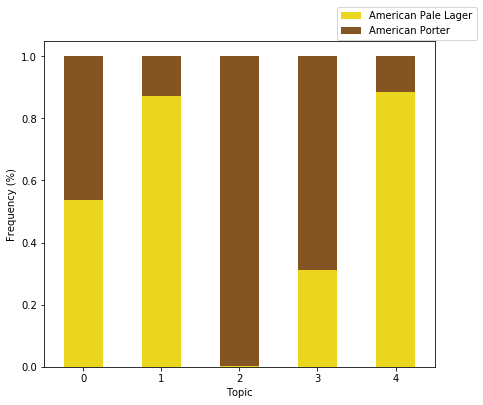

In [278]:
df = pd.DataFrame(doc_topic_matrix)
df['style_name'] = [d['style_name'] for d in beer_reviews[0]]
df['top_topic'] = get_top_topic(model, doc_topic_matrix)

print(pd.crosstab(df['style_name'], df['top_topic']))

ct = pd.crosstab(df['top_topic'], df['style_name'])
ct = ct.apply(lambda r: r / r.sum(), axis=1)

beer_plot = ct.plot.bar(stacked=True, color=['#ead61c', '#845422'],
                        edgecolor='none', lw=2, rot=0, figsize=(7, 6))
beer_plot.set_xlabel('Topic')
beer_plot.set_ylabel('Frequency (%)')
beer_plot.legend(bbox_to_anchor=(1.12, 1.12))

plt.show()

In [279]:
ct.to_csv(data_path + '2_styles_top_topic_1gram_xtab.csv')
df.to_csv(data_path + '2_styles_doc_topic_1gram_matrix.csv')

In [276]:
# 2-grams

In [255]:
tl_textacy = (doc.to_terms_list(ngrams=2, named_entities=True, as_strings=True) 
              for doc in texty_texts)

vec_specs = {'weighting': 'tfidf',
             'normalize': 'True',
             'smooth_idf': 'True',
             'min_df': 5,
             'max_df': 0.95}
vectorizer = textacy.Vectorizer(**vec_specs)
doc_term_matrix = vectorizer.fit_transform(tl_textacy)

In [266]:
model = textacy.tm.TopicModel('lda', n_topics=5, random_state=123)
model.fit(doc_term_matrix)

In [267]:
doc_topic_matrix = model.transform(doc_term_matrix)

In [268]:
for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term):
    print('topic', topic_idx, ':', '   '.join(top_terms))

topic 0 : tan head   dark fruit   dark brown   roast malt   brown color   roasted malt   pint glass   medium body   brown sugar   light brown
topic 1 : dark chocolate   roasted malt   peanut butter   milk chocolate   tan head   dark brown   roast malt   roasted coffee   coffee flavor   coffee bean
topic 2 : white head   light body   pale lager   macro lager   sweet malt   yellow color   pint glass   small head   pumpkin beer   little head
topic 3 : white head   floral hop   earthy hop   hop flavor   pale malt   bready malt   citrus hop   herbal hop   grassy hop   medium body
topic 4 : pint glass   good beer   half   half finger   white head   first   beer -pron-   little bit   finger head   -pron- way


In [269]:
df = pd.DataFrame(doc_topic_matrix)
df['style_name'] = [d['style_name'] for d in beer_reviews[0]]
df['top_topic'] = get_top_topic(model, doc_topic_matrix)

print(pd.crosstab(df['style_name'], df['top_topic']))

top_topic               0     1     2     3     4
style_name                                       
American Pale Lager   186    83  1615  2346  2620
American Porter      4645  5501   255   233   541


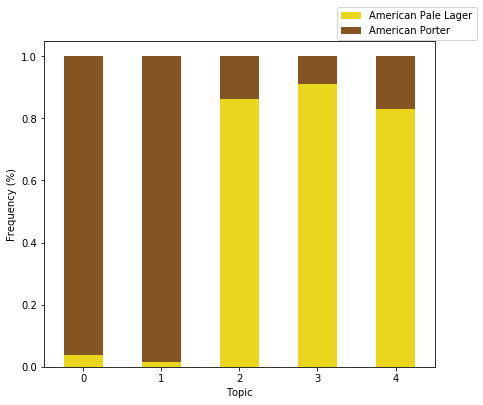

In [270]:
ct = pd.crosstab(df['top_topic'], df['style_name'])
ct = ct.apply(lambda r: r / r.sum(), axis=1)

beer_plot = ct.plot.bar(stacked=True, color=['#ead61c', '#845422'],
                        edgecolor='none', lw=2, rot=0, figsize=(7, 6))
beer_plot.set_xlabel('Topic')
beer_plot.set_ylabel('Frequency (%)')
beer_plot.legend(bbox_to_anchor=(1.12, 1.12))

plt.show()

### Some Outputs for proper plots with R

In [275]:
ct.to_csv(data_path + '2_styles_top_topic_xtab.csv')
df.to_csv(data_path + '2_styles_doc_topic_matrix.csv')

### Clustering k-means

In [281]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
km.fit(doc_topic_matrix)
clusters = km.labels_.tolist()

ImportError: cannot import name 'check_memory'